In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Layer, Conv2D, MaxPool2D, Flatten
from keras.losses import Loss
from keras.optimizers import Optimizer
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical, plot_model, load_img, img_to_array

from keras.models import load_model

# Functions: Import and process data

In the following code block we have the functions ``show_img``, ``single_img`` and ``plot_single_img``. They are used to show a single image from the dataset, create a batch of size 1 for the image (i.e. expand one dimension) to pass for the model, and show image passed as input along side of the probability of correctness.

In [3]:
def show_img(data):
    # show figures in the dataset
    fig = plt.figure(figsize = (24,3))
    plt.imshow(data.reshape(28,28) , cmap = plt.get_cmap('gray'))
    plt.show()
    
def single_img(img_array):
    img_batch = np.expand_dims(img_array, axis=0)
    return img_batch

def plot_single_img(img, prediction):
    fig, ax = plt.subplots(1,2, figsize = (20,10))

    ax[0].imshow(img.reshape(28,28) , cmap = plt.get_cmap('gray'))
    
    ax[1].bar(range(10), prediction[0], color = 'black' )
    ax[1].set_xlabel('$Numbers$', color = "gray", fontsize =20)
    ax[1].set_ylabel('$Prob$', color = "gray", fontsize =20)
    ax[1].set_title('Probability of correct number', color = 'gray',fontsize =20)
    ax[1].set_xticks(range(11))
    ax[1].set_yticks([])
    ax[1].tick_params(axis ='x', colors = 'gray', labelsize = 15)

    plt.show()
    


The ``load_data`` function reads two CSV files containing the training and testing data, respectively. The CSV files are assumed to have the following format: the first column contains the label of the image (i.e., the digit it represents), and the remaining 784 columns (28 x 28 pixels) contain the pixel values of the image. The function returns a tuple of tuples, where the first tuple contains the training data (pixel values and labels), and the second tuple contains the testing data (pixel values and one-hot encoded labels).

In [4]:
def load_data():
    
    train = pd.read_csv('data/mnist_train_small.csv')
    test = pd.read_csv('data/mnist_test_small.csv')

    y_train = train['label'].to_numpy()
    x_train = train.drop('label', axis = 1).to_numpy()
    y_test = test['label'].to_numpy()
    x_test = test.drop('label', axis = 1).to_numpy()
    
    # reshape dataset to have a single channel
    # Reshape (20000,784) ->  (2000,     28,     28,     1)
    x_test = x_test.reshape(x_test.shape[0],28,28,1)
    x_train = x_train.reshape(x_train.shape[0],28,28,1)
    # one hot encode target values
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)

    return (x_train, y_train), (x_train, y_test)

The ``scale_pixels`` function normalize the dataset. Note that normalizing the dataset does not change the appearance of the images. if you normalize an image by dividing each pixel value by 255, you are scaling the range of values from $[0, 255]$ $\to$ $[0, 1]$.

When we normalize the pixel values of an image, we typically scale them so that they have a mean of 0 and a standard deviation of 1. This can help improve the performance of the CNN model.

In [5]:
def scale_pixels(train, test):
    # normalize the data to a range of [0 1] and convert to float
    train_norm = train.astype('float32') / 255.0
    test_norm = test.astype('float32') / 255.0

    return train_norm, test_norm

# Classes: CNN Model

One possible approach for this model of classification is to create two classes heiress from the class ``Model``, one for the convolutional and pooling layers, and another for the fully connected neural network layers. This approach allows for modular design and easier customization of the CNN architecture.

We can intercalate ``Conv2D`` layers with ``MaxPool2D`` layers. This allows the network to learn hierarchical features of increasing complexity and abstraction, while reducing the spatial dimensionality of the feature maps and improving the computational efficiency of the network. Because of this dependency in intercalate layers, is necessary that the list with filters sizes and the list with the pool sizes be of equal length.

Remember, The filter size of a ``Conv2D`` layer is a hyperparameter that determines the spatial size of the filter kernel that slides over the input image. The filter size is usually a small square matrix, typically $3\times 3$ or $5 \times 5$. The filter size determines the size of the receptive field of the layer, which is the region of the input that each neuron in the layer is connected to. On the other hand, The pool size of a ``MaxPooling2D`` layer represents the size of the window that is used for pooling. This window slides over the input feature map in two dimensions and outputs the maximum value in each window. For example, a MaxPooling2D layer with a pool size of $(2,2)$ will divide the input feature map into non-overlapping rectangular regions of size 2x2 and output the maximum value in each region.

Note that Choosing different filter sizes and pool sizes allows for greater flexibility in designing a CNN architecture that can effectively learn from the input data. 

- **Filter sizes:**
  
    - **Larger filter sizes**:  CNN can detect smaller and more intricate features in the image. This can be useful when working with images that contain fine details, such as edges or small textures. However, smaller filters also lead to more convolutions, which can increase the computational cost of the network.

    - **Smaller filter sizes**: CNN can detect larger features in the image. This can be useful when working with images that contain larger features, such as objects or patterns that cover a large area of the image. However, larger filters can also lead to a loss of spatial resolution and details in the image, especially in deeper layers of the network.

- **Pool sizes:**

  - **Larger pool sizes**: Can lead to a more precise localization of features in the input image, as less information is lost due to downsampling. However, smaller pool sizes can also increase the chance of overfitting, as the model may become too focused on details that are specific to the training set.

  - **Smaller pool sizes**: Can lead to a more generalized representation of the input, as more information is lost due to downsampling. This can help prevent overfitting, as the model is forced to learn more abstract representations that are applicable to a wider range of inputs. However, larger pool sizes can also result in a loss of important features in the input, which can lead to decreased performance.


Another important factor to consider is the depth and width of the network. Increasing the depth of the network (i.e., the number of layers) can improve the representational capacity of the network, but may also lead to overfitting or computational inefficiencies. Similarly, increasing the width of the network (i.e., the number of filters in each layer) can improve the discriminative power of the network, but may also increase the computational cost and memory requirements.

In [6]:
class CNN(Model):
    
    def __init__(self, 
                 nn_model, 
                 img_shape: tuple = (28, 28, 1), 
                 filters: list = [32, 64], 
                 filter_size: tuple = (3, 3), 
                 pool_sizes: list = [(2, 2), (2, 2)], 
                 activation: str = 'relu', 
                 initializer: str = 'he_uniform') -> None:
        """
        Constructor for the CNN class.

        Parameters:
        nn_model (Model): The model to be used in the final fully connected layer for classification.
        img_shape (tuple): The shape of the input image.
        filters (list): A list containing the number of filters to be used in each convolutional layer.
        filter_size (tuple): The size of the filters to be used in each convolutional layer.
        pool_sizes (list): A list containing the size of the maxpooling layer to be applied after each convolutional layer.
        activation (str): The activation function to be used in the convolutional layers.
        initializer (str): The initializer to be used in the convolutional layers.
        """
        super(CNN, self).__init__()
        self.nn_model = nn_model
        self.img_shape = img_shape
        self.filters = filters
        self.filter_size = filter_size
        self.pool_sizes = pool_sizes
        self.activation = activation
        self.initializer = initializer

        # create convolutional layers
        self.conv2d = []
        count = 0
        for filter in filters:
            self.conv2d.append(Conv2D(filters=filter, kernel_size=self.filter_size, kernel_initializer=self.initializer,
                                      input_shape=img_shape, activation=self.activation, name='Conv2D_{}'.format(count)))
            count += 1

        # create maxpooling layers
        self.maxpool = []
        count = 0
        for size in pool_sizes:
            self.maxpool.append(MaxPool2D(pool_size=size, name='MaxPool_{}'.format(count)))
            count += 1

        # create flatten layer
        self.flatten = Flatten(name='Flatten')

    def call(self, x):
        """
        Forward pass of the network.

        Parameters:
        x: Input tensor.

        Returns:
        x: Output tensor.
        """
        for conv_layer, maxpool_layer in zip(self.conv2d, self.maxpool):
            x = conv_layer(x)
            x = maxpool_layer(x)
        x = self.flatten(x)
        x = self.nn_model(x)
        return x

    def build(self):
        """
        Intermediate step to generate a graph.

        Returns:
        model: The model generated with the CNN class.
        """
        x = Input(shape=self.img_shape, name="Input")
        model = Model(inputs=x, outputs=self.call(x), name="CNN")
        return model

In [8]:
class NN(Model):
    def __init__(
        self,
        hidden_units: list = [128],
        output_unit: int = 10,
        output_activation: str = "softmax",
        activation: str = "relu",
        initializer: str = "he_uniform"
    ) -> None:
        """
        Constructor for the NN class.

        Parameters:
        hidden_units (list): A list containing the number of units to be used in each hidden layer.
        output_unit (int): The number of units to be used in the output layer.
        output_activation (str): The activation function to be used in the output layer.
        activation (str): The activation function to be used in the hidden layers.
        initializer (str): The initializer to be used in the hidden layers.
        """
        super(NN, self).__init__()

        self.units = hidden_units
        self.output_unit = output_unit
        self.activation_func = activation
        self.output_activation = output_activation
        self.initializer = initializer

        # Hidden Layers
        self.hidden_layer = []
        count = 0
        for unit in hidden_units:
            self.hidden_layer.append(
                Dense(
                    units=unit,
                    kernel_initializer=self.initializer,
                    activation=activation,
                    name=f"Hidden_{count}"
                )
            )
            count += 1

        # Output Layer
        self.output_layer = Dense(
            units=output_unit,
            kernel_initializer=self.initializer,
            activation=output_activation,
            name="Output"
        )

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        Forward step of the network.

        Parameters:
        x (tf.Tensor): Input tensor.

        Returns:
        tf.Tensor: Output tensor.
        """
        for hidden in self.hidden_layer:
            x = hidden(x)
        x = self.output_layer(x)
        return x

## Model Summary

In [9]:
nn_model = NN()
cnn_model = CNN(nn_model).build()

cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 Conv2D_0 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 MaxPool_0 (MaxPooling2D)    (None, 13, 13, 32)        0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 MaxPool_1 (MaxPooling2D)    (None, 5, 5, 64)          0         
                                                                 
 Flatten (Flatten)           (None, 1600)              0         
                                                                 
 nn (NN)                     (None, 10)                206218  

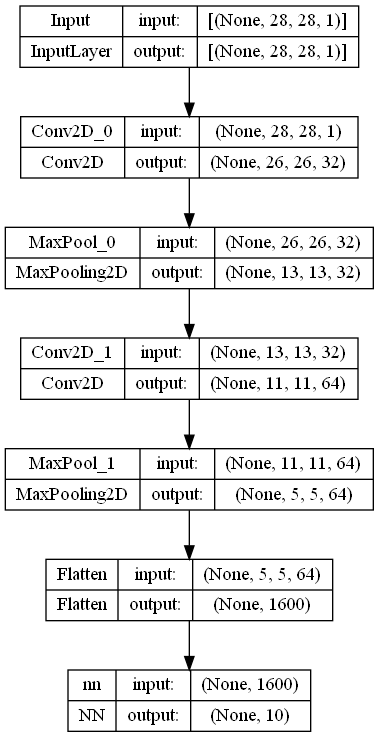

In [10]:
plot_model(cnn_model, show_shapes=True, show_layer_names=True)

# Main

In [11]:
# Data Pre-Processing
train, test = load_data()
x_train, y_train  = train[0], train[1]
x_test, y_test  = test[0], test[1]

x_train, x_test = scale_pixels(x_train, x_test)

# Show images
#print(x_train[1997].shape)
#plot_img(x_test[10])

# Model
nn_model = NN()
cnn_model = CNN(nn_model).build()

# Compile and fit
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = tf.optimizers.Adam(learning_rate=0.001),metrics=['accuracy'])
cnn_model.fit(x = x_train, y = y_train, epochs=10, batch_size=32)


Epoch 1/10
625/625 [==============================] - 8s 11ms/step - loss: 0.2178 - accuracy: 0.9312
Epoch 2/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0603 - accuracy: 0.9807
Epoch 3/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0372 - accuracy: 0.9881
Epoch 4/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0275 - accuracy: 0.9908
Epoch 5/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0209 - accuracy: 0.9933
Epoch 6/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0125 - accuracy: 0.9962
Epoch 7/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0144 - accuracy: 0.9952
Epoch 8/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0112 - accuracy: 0.9962
Epoch 9/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0082 - accuracy: 0.9970
Epoch 10/10
625/625 [==============================] - 7s 11ms/step - loss: 0.0093 - accura

# Predict single image and plot

1/1 [==============================] - 0s 101ms/step
[[5.4881470e-23 2.1335578e-20 1.2664893e-21 1.3209818e-12 9.6311945e-22
  1.0000000e+00 1.0137270e-15 2.3176830e-16 1.0265471e-12 4.0375594e-13]]


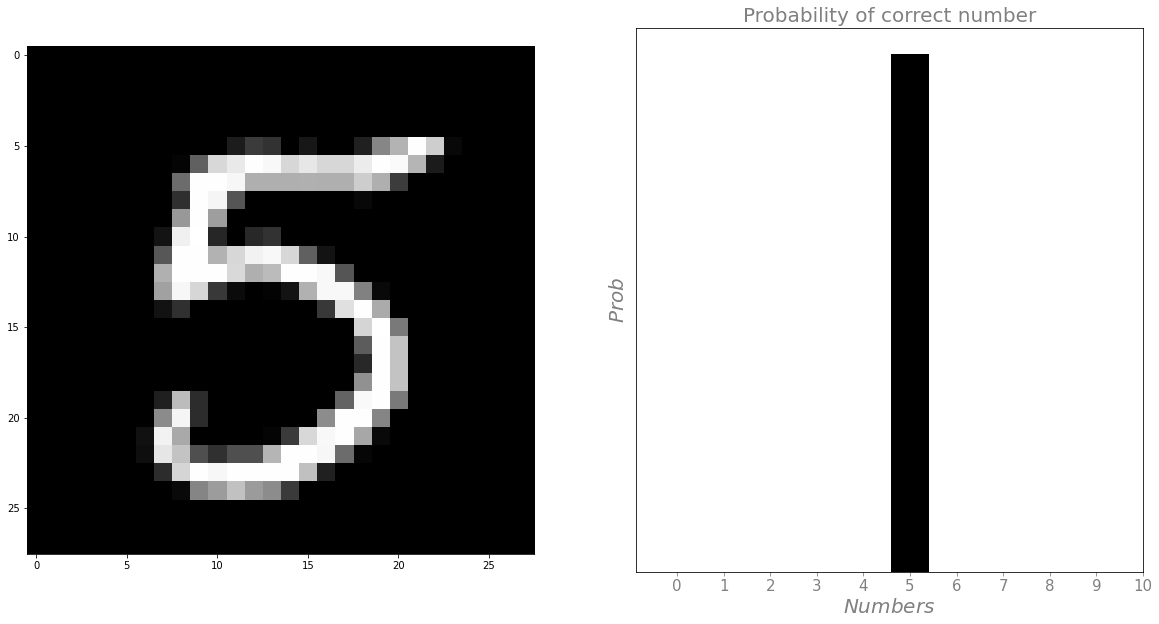

In [12]:
img_batch = single_img(x_test[1])
prediction = cnn_model.predict(img_batch)
print(prediction)

plot_single_img(img_batch, prediction)